In [2]:
import torch
import numpy as np
from torchvision.transforms import transforms as T
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
sys.path.append('..')
sys.path.append('../dataset_loader')
sys.path.append('../model')
from config import *
from mpl_toolkits.axes_grid1 import make_axes_locatable


from dataset_loader.image_loader import *
from model.resunet import *
from utils import *

from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

In [4]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [5]:
"../model_results/autoencoder/green/c-resunet_g_ae/" 

'../model_results/autoencoder/green/c-resunet_g_ae/'

In [6]:
path = "../model_results/autoencoder/green/c-resunet_g_ae/" 

In [7]:
for ix,m in enumerate(os.listdir(path)):
    print(ix,m)

0 c-resunet_g_ae.h5


In [8]:
model_name = os.listdir(path)[0]#21
print(model_name)

c-resunet_g_ae.h5


In [9]:
try:
    c0=True

    model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16, n_out = 3,c0=c0,
            pretrained = False, progress= True)).to(device)
    model.load_state_dict(torch.load(path + '{}'.format(model_name))['model_state_dict'])
except:
    print('no c0 is used')
    c0=False

    model = nn.DataParallel(c_resunet(arch='c-ResUnet', n_features_start = 16, n_out = 3,c0=c0,
            pretrained = False, progress= True)).to(device)
    model.load_state_dict(torch.load(path + '{}'.format(model_name))['model_state_dict'])

including c0 in the network
Initializing conv2d weights with Kaiming He normal


In [10]:
test = False
dataset = 'green'

str(root).replace('notebook', '') + '/data/test/original_images/'

transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor()
                       ])

cells_images = CellsLoader(Path(str(root).replace('notebook', '') + '/data/train_val/images/'),
                            Path(str(root).replace('notebook', '') + '/data/train_val/masks/'), 
                               val_split=0.3, transform = transform, test = test, exclude_RT=True)

filenames = cells_images.imgs_list

removing from test image RT428S4C3R1_ParCort_100x_g.png
removing from test image RT428S6C3R1_VLPAG_100x_g.png
removing from test image RT429S6C3R3_RVLM_100x_g.png
removing from test image RT466S5C1R1_LH_100x_g.png
removing from test image RT463S3C3R1_LH_100x_g.png
removing from test image RT433S5C2R2_MM_100x_g.png
removing from test image RT429S5C4R1_MM_100x_g.png
removing from test image RT428S5C4R1_MM_100x_g.png
removing from test image RT426S2C1R1_Septum_100x_g.png
removing from test image RT418S4C1R1_ParCort_100x_g.png
removing from test image RT418S7C1R1_VLPAG_100x_g.png
removing from test image RT418S9C2R1_RVLM_100x_g.png
removing from test image RT433S6C3R2_RVLM_100x_g.png
removing from test image RT433S4C1R2_DM_100x_g.png
removing from test image RT466S2C3R2_Septim_100x_g.png
removing from test image RT429S3C3R1_LH_100x_g.png
removing from test image RT426S5C1R1_MM_100x_g.png
removing from test image RT426S4C1R1_ParCort_100x_g.png
removing from test image RT429S4C3R3_VLPAG_100x

In [11]:
labels_df = pd.read_csv(str(labels_csv).replace('preprocessing', ''))
img_names = labels_df['img_name'].values
labels_df.set_index(['img_name'], inplace=True)

In [12]:
RADIUS = 20

In [29]:
result = model(img.to(device))

In [30]:
result.shape

torch.Size([1, 3, 1200, 1600])

In [33]:
# model inference
for ix, f in enumerate(filenames):
    img = cv2.imread(str(train_val_images) + '/' +f)
    img = transform(img)
    img = torch.unsqueeze(img, 0)
    img = img.to(device).float()

    with torch.no_grad():
        print("image {} num {} ".format(f, ix))
        model.eval()
        result = model(img.to(device))
        result = np.squeeze(torch.sum(result,1).detach().cpu().numpy())
        
            
    heat_map = (torch.from_numpy(result) - torch.from_numpy(result).min())\
                /(torch.from_numpy(result).max() - torch.from_numpy(result).min())
    med = torch.median(torch.flatten(heat_map))
    
    if med > 0.5:
        heat_map = 1 - heat_map
        
    th = 0.60
    preds_t = (heat_map > th)
    

    # already circle images around dot annotation
    #mask = cv2.imread(str(train_val_masks) + '/' +f)
    #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)[:, :, 0:1]
    
    mask = np.zeros((IMG_HEIGHT,IMG_WIDTH,3), np.uint8)
    mask.fill(0)
    print('\nGenerating mask for folder {}\n'.format(f))

    try:
        for index, r in labels_df.loc[f].iterrows():
            coords = r['dot']
            coords = [float(x.strip('(),')) for x in coords.split()]
            y, x = coords[0], coords[1]
            if 'RT' in f:
                cv2.circle(mask, (int(x), int(y)), RADIUS_RT, [255, 255, 255], -1)
            else:
                cv2.circle(mask, (int(x), int(y)), RADIUS, [255, 255, 255], -1)
    except:
        print('no coord for ',f)

    
    #mask_ws = create_mask(centers, f, radius=30, h=1200, w=1600)
    #mask_ws =  mask_ws.astype(bool)
    mask_ws = np.logical_and(np.squeeze(mask[:,:, 0]), preds_t)

    torch.cuda.empty_cache()
    
    
    plt.imsave(os.path.join(str(train_val_ws_masks), f.split('.')[0]+'.tiff'),
               mask_ws, cmap='gray')

image Mar26bS2C2R3_LHl_200x_g.png num 0 

Generating mask for folder Mar26bS2C2R3_LHl_200x_g.png

image Mar24bS2C4R3_LHl_200x_g.png num 1 

Generating mask for folder Mar24bS2C4R3_LHl_200x_g.png

image Mar19bS2C1R2_LHr_200x_g.png num 2 

Generating mask for folder Mar19bS2C1R2_LHr_200x_g.png

image Mar21bS1C4R2_DMr_200x_g.png num 3 

Generating mask for folder Mar21bS1C4R2_DMr_200x_g.png

image Mar24bS1C2R2_DMl_200x_g.png num 4 

Generating mask for folder Mar24bS1C2R2_DMl_200x_g.png

image Mar26bS1C4R3_DMl_200x_g.png num 5 

Generating mask for folder Mar26bS1C4R3_DMl_200x_g.png

image Mar20bS1C4R1_LHr_200x_g.png num 6 

Generating mask for folder Mar20bS1C4R1_LHr_200x_g.png

image Mar20bS2C1R3_DMr_200x_g.png num 7 

Generating mask for folder Mar20bS2C1R3_DMr_200x_g.png

image Mar19bS1C5R2_DMl_200x_g.png num 8 

Generating mask for folder Mar19bS1C5R2_DMl_200x_g.png

image Mar24bS1C2R1_DMl_200x_g.png num 9 

Generating mask for folder Mar24bS1C2R1_DMl_200x_g.png

image Mar26bS1C2R1_V

image Mar20bS1C1R3_VLPAGl_200x_g.png num 82 

Generating mask for folder Mar20bS1C1R3_VLPAGl_200x_g.png

image Mar26bS2C2R2_LHr_200x_g.png num 83 

Generating mask for folder Mar26bS2C2R2_LHr_200x_g.png

image Mar24bS1C2R2_LHr_200x_g.png num 84 

Generating mask for folder Mar24bS1C2R2_LHr_200x_g.png

image Mar21bS2C1R3_LHr_200x_g.png num 85 

Generating mask for folder Mar21bS2C1R3_LHr_200x_g.png

image Mar23bS1C6R1_DMr_200x_g.png num 86 

Generating mask for folder Mar23bS1C6R1_DMr_200x_g.png

image Mar19bS2C1R1_LHr_200x_g.png num 87 

Generating mask for folder Mar19bS2C1R1_LHr_200x_g.png

image Mar24bS2C2R3_VLPAGr_200x_g.png num 88 

Generating mask for folder Mar24bS2C2R3_VLPAGr_200x_g.png

image Mar20bS2C3R1_LHr_200x_g.png num 89 

Generating mask for folder Mar20bS2C3R1_LHr_200x_g.png

image Mar21bS2C1R1_LHl_200x_g.png num 90 

Generating mask for folder Mar21bS2C1R1_LHl_200x_g.png

image Mar23bS1C5R3_LHl_200x_g.png num 91 

Generating mask for folder Mar23bS1C5R3_LHl_200x_g.png

image Mar22bS1C2R1_VLPAGl_200x_g.png num 163 

Generating mask for folder Mar22bS1C2R1_VLPAGl_200x_g.png

image Mar23bS1C2R4_VLPAGl_200x_g.png num 164 

Generating mask for folder Mar23bS1C2R4_VLPAGl_200x_g.png

image Mar19bS1C5R2_LHr_200x_g.png num 165 

Generating mask for folder Mar19bS1C5R2_LHr_200x_g.png

image Mar26bS1C4R2_LHr_200x_g.png num 166 

Generating mask for folder Mar26bS1C4R2_LHr_200x_g.png

image Mar19bS1C4R2_DMl_200x_g.png num 167 

Generating mask for folder Mar19bS1C4R2_DMl_200x_g.png

image Mar24bS1C2R1_LHl_200x_g.png num 168 

Generating mask for folder Mar24bS1C2R1_LHl_200x_g.png

image Mar24bS1C3R2_LHr_200x_g.png num 169 

Generating mask for folder Mar24bS1C3R2_LHr_200x_g.png

image Mar23bS1C5R2_LHr_200x_g.png num 170 

Generating mask for folder Mar23bS1C5R2_LHr_200x_g.png

image Mar21bS2C2R2_DMr_200x_g.png num 171 

Generating mask for folder Mar21bS2C2R2_DMr_200x_g.png

image Mar22bS1C3R1_DMl_200x_g.png num 172 

Generating mask for folder Mar22bS1C3R1_DMl_

In [21]:
preds_t.shape

torch.Size([1, 3, 1200, 1600])

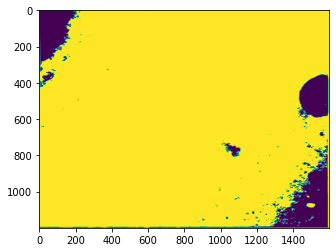

In [22]:
plt.imshow(preds_t)

In [18]:
# model inference
for ix, f in enumerate(filenames):
    img = cv2.imread(TrainValImages + f)
    img = transform(img)
    img = torch.unsqueeze(img, 0)
    img = img.to(device).float()

    with torch.no_grad():
        print("image {} num {} ".format(f, ix))
        outputs = []
        for layer in conv_layers[0:]:
            img = layer(img)
            outputs.append(img)
            
        #processed = []
        #for feature_map in outputs[-1:]:
        feature_map = outputs[-4].squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        result = gray_scale.data.cpu().numpy()
            
    heat_map = (torch.from_numpy(result) - torch.from_numpy(result).min())\
                /(torch.from_numpy(result).max() - torch.from_numpy(result).min())
    med = torch.median(torch.flatten(heat_map))
    if med > 0.5:
        heat_map = 1 - heat_map
        
    th = 0.60
    preds_t = (heat_map > th)
    
    # extract target objects and counts
    mask = cv2.imread(str(TrainValMasks)+ '/' + f)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)[:, :, 0:1]
    centers = find_centers(mask)
    

    mask_ws = create_mask(centers, f, radius=30, h=1200, w=1600)
    mask_ws =  mask_ws.astype(bool)
    mask_ws = np.logical_and(np.squeeze(mask_ws[:,:, 0]), preds_t)

    torch.cuda.empty_cache()
    
    
    plt.imsave(os.path.join(str(TrainValMasksWSAE), f.split('.')[0]+'.tiff'),
               mask_ws, cmap='gray')

NameError: name 'filenames' is not defined

In [84]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [85]:
cntrs=[]
for c in centers:
    cntrs.append([c[1],c[0]])

In [87]:
vor = Voronoi(np.array(cntrs))

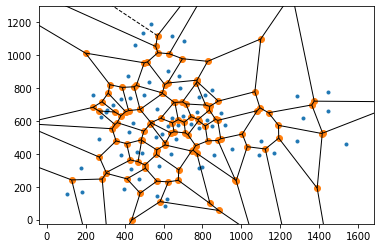

In [88]:
import matplotlib.pyplot as plt

fig = voronoi_plot_2d(vor)

plt.show()

In [16]:
if dataset == 'yellow':
    priority_list = ['254.tiff', '275.tiff', '81.tiff', '278.tiff', '279.tiff', '281.tiff', '273.tiff'
                    ,'50.tiff']
    cells_images = CellsLoader(root + "/DATASET/test/all_images/images/",
                               root + "/DATASET/test/all_masks/masks/", 
                               val_split=0.3, transform = transform, test = test, 
                               priority_list=priority_list)
elif dataset == 'red':
    priority_list = []
    cells_images = CellsLoader(root + "/DATASET/fine_tuning/red/test/all_images/images/",
                               root + "/DATASET/fine_tuning/red/test/all_masks/masks/", 
                               val_split=0.3, transform = transform, test = test)

#cells_images = CellsLoader(root + "/DATASET/train_val/crop_augmented/images/",
#                           root + "/DATASET/train_val/crop_augmented/masks/", 
#                           val_split=0.3, transform = transform, ae = ae, test = False)

In [17]:
batch_size = 8
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [18]:
x, y = next(iter(test_loader))

In [19]:
blocks = list(model.module.children()) #encoder, decoder, head

In [20]:
counter=0
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
layers = []# get all the model children as list
for block in blocks:
    for n,p in list(block.named_modules()):
        if type(p) == nn.Conv2d:
            counter+=1
            model_weights.append(p.weight)
            layers.append(p)

In [21]:
for ix, l in enumerate(layers):
    print(ix, l)

0 Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
1 Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
2 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
4 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
5 Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
6 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
7 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
9 Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
10 Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
11 Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
12 Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
13 Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
14 Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 Conv2d(64, 64, kernel_size=(3,

In [22]:
remove = [5,8,11]

In [23]:
conv_layers = []
remove = [5,8,11]
for i, l in enumerate(layers):
    if i not in remove:
        conv_layers.append(l)

In [24]:
image = x[5].unsqueeze(0).to(device)

In [25]:
#conv_layers = conv_layers[0:4]

In [26]:
conv_layers

[Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [27]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

18
torch.Size([1, 1, 1200, 1600])
torch.Size([1, 16, 1200, 1600])
torch.Size([1, 16, 1200, 1600])
torch.Size([1, 32, 1200, 1600])
torch.Size([1, 32, 1200, 1600])
torch.Size([1, 64, 1200, 1600])
torch.Size([1, 64, 1200, 1600])
torch.Size([1, 128, 1200, 1600])
torch.Size([1, 128, 1200, 1600])
torch.Size([1, 128, 1200, 1600])
torch.Size([1, 128, 1200, 1600])
torch.Size([1, 64, 1200, 1600])
torch.Size([1, 64, 1200, 1600])
torch.Size([1, 32, 1200, 1600])
torch.Size([1, 32, 1200, 1600])
torch.Size([1, 16, 1200, 1600])
torch.Size([1, 16, 1200, 1600])
torch.Size([1, 3, 1200, 1600])


In [28]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
    
for fm in processed:
    print(fm.shape)

(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)


(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)
(1200, 1600)


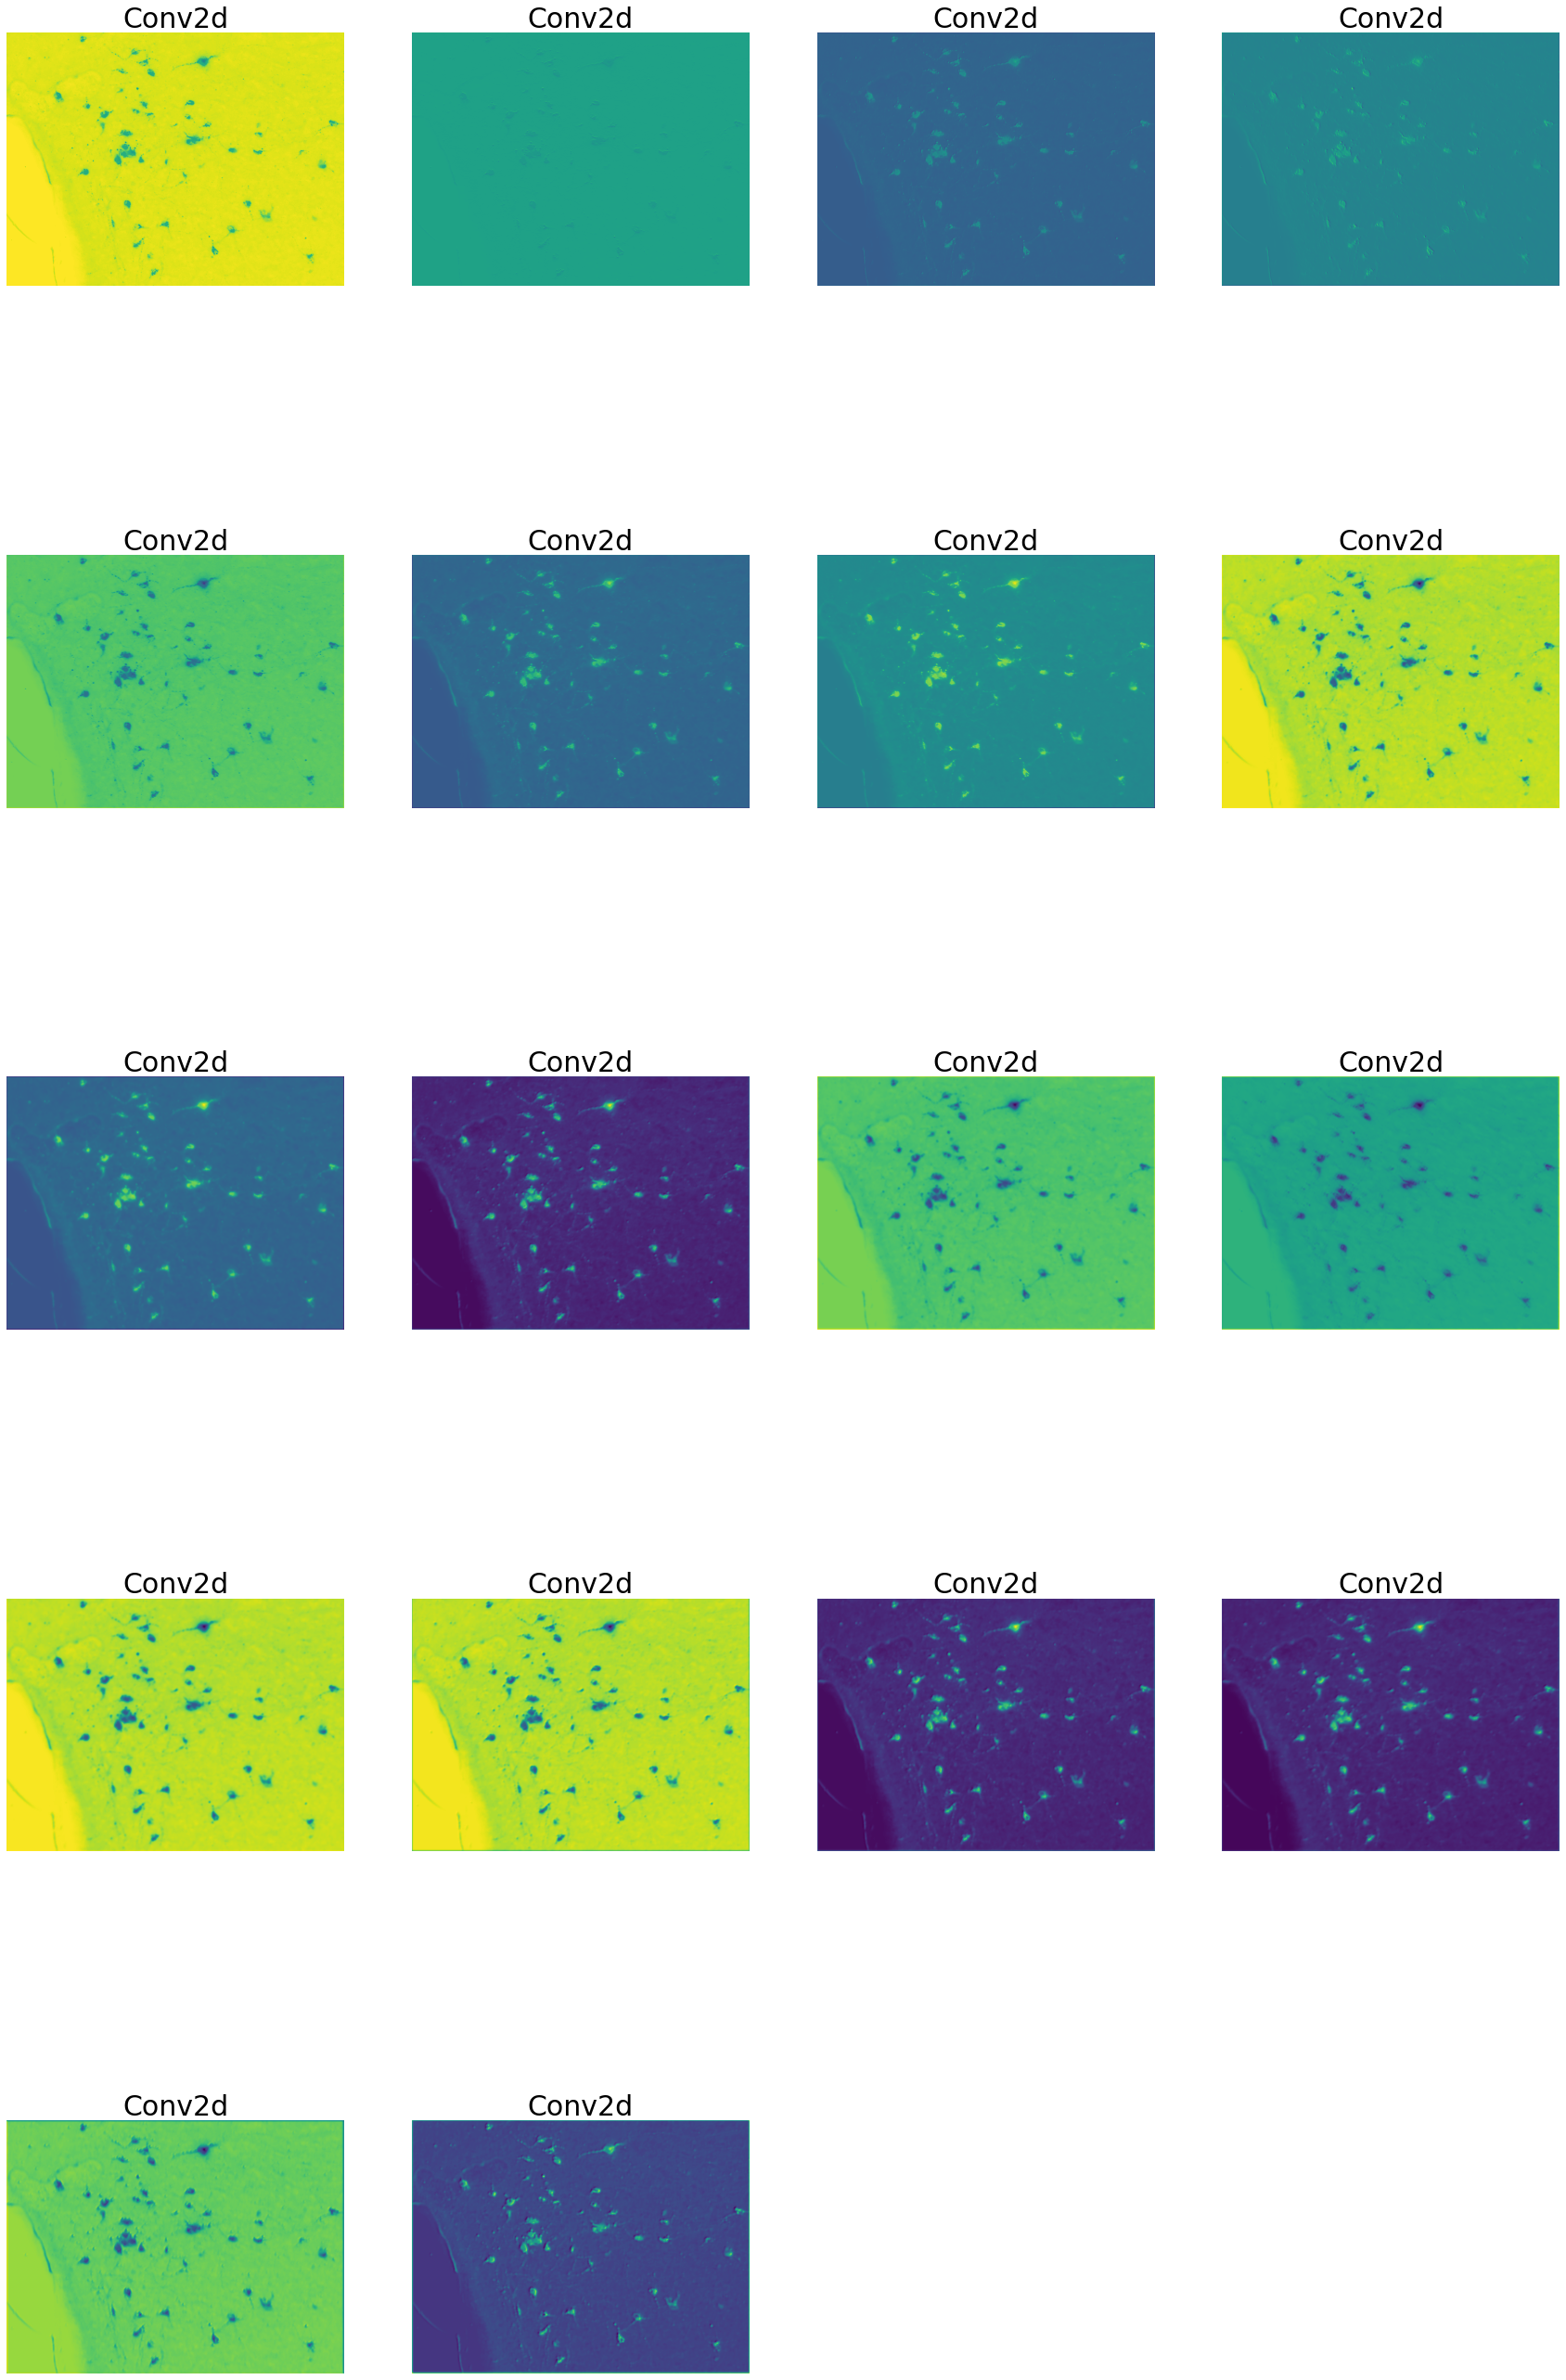

In [29]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    print(processed[i].shape)
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

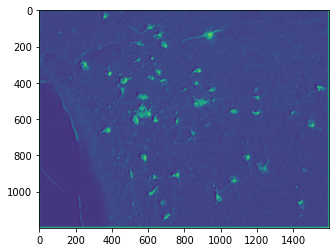

In [37]:
plt.imshow(processed[-1])

In [38]:
fm = processed[-4]

In [39]:
#heat_map_a = torch.nn.Sigmoid()(torch.from_numpy(fm))
heat_map_a = (torch.from_numpy(fm) - torch.from_numpy(fm).min())\
/(torch.from_numpy(fm).max() - torch.from_numpy(fm).min())

In [40]:
heat_map = torch.from_numpy(fm)

In [41]:
(heat_map_a==1).sum()

tensor(1)

In [42]:
med = torch.median(torch.flatten(heat_map_a))
if med > 0.5:
    heat_map_a = 1 - heat_map_a

th = 0.3
heat_map_a = (heat_map_a > th)

Text(0.5, 1.0, 'Predicted heatmap')

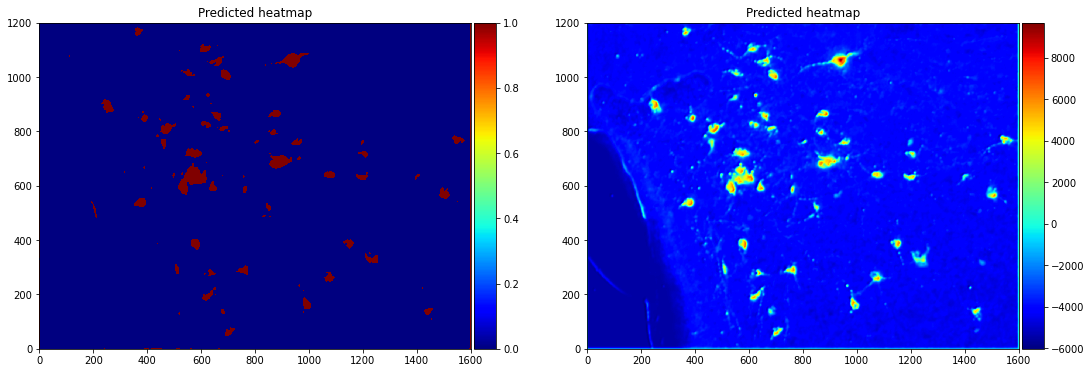

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

im = axes[0].pcolormesh(np.flipud(heat_map_a.cpu().detach().squeeze()), cmap='jet')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
axes[0].set_title('Predicted heatmap') 

im = axes[1].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
axes[1].set_title('Predicted heatmap') 

In [61]:
torch.median(torch.flatten(heat_map_a))

heat_map_a = 1- heat_map_a 

tensor(0.2161)

Text(0.5, 1.0, 'Predicted heatmap')

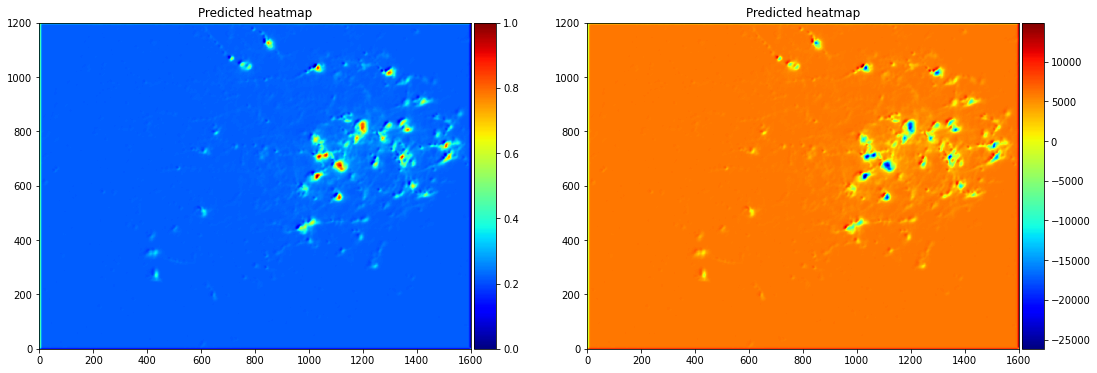

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

im = axes[0].pcolormesh(np.flipud(heat_map_a.cpu().detach().squeeze()), cmap='jet')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
axes[0].set_title('Predicted heatmap') 

im = axes[1].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
axes[1].set_title('Predicted heatmap') 

In [ ]:
nn.

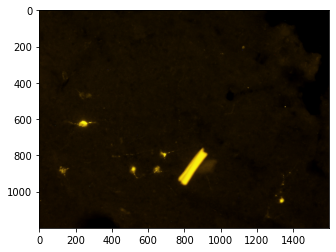

In [12]:
plt.imshow(x[0].permute(1,2,0))

In [87]:
for name, module in model.named_modules():
    print(name)


module
module.encoder
module.encoder.colorspace
module.encoder.conv_block
module.encoder.conv_block.conv_block
module.encoder.conv_block.conv_block.batchnorm2d_0
module.encoder.conv_block.conv_block.activation_1
module.encoder.conv_block.conv_block.conv2d_2
module.encoder.conv_block.conv_block.batchnorm2d_3
module.encoder.conv_block.conv_block.activation_4
module.encoder.conv_block.conv_block.conv2d_5
module.encoder.pool1
module.encoder.residual_block1
module.encoder.residual_block1.conv_path
module.encoder.residual_block1.conv_path.conv_block
module.encoder.residual_block1.conv_path.conv_block.batchnorm2d_0
module.encoder.residual_block1.conv_path.conv_block.activation_1
module.encoder.residual_block1.conv_path.conv_block.conv2d_2
module.encoder.residual_block1.conv_path.conv_block.batchnorm2d_3
module.encoder.residual_block1.conv_path.conv_block.activation_4
module.encoder.residual_block1.conv_path.conv_block.conv2d_5
module.encoder.residual_block1.id_path
module.encoder.residual_bl

In [129]:
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
    return hook


In [133]:
model.module.encoder.colorspace.register_forward_hook(getActivation('module.encoder.colorspace'))

In [98]:
blocks = list(list(model.children())[0].children())

In [107]:
list(b.children())

[Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1)),
 ConvBlock(
   (conv_block): ModuleDict(
     (batchnorm2d_0): BatchNorm2d(1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
     (activation_1): ELU(alpha=1.0)
     (conv2d_2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (batchnorm2d_3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
     (activation_4): ELU(alpha=1.0)
     (conv2d_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   )
 ),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ResidualBlock(
   (conv_path): ConvBlock(
     (conv_block): ModuleDict(
       (batchnorm2d_0): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
       (activation_1): ELU(alpha=1.0)
       (conv2d_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (batchnorm2d_3): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, 

In [119]:
counter = 0 

In [117]:
for b in blocks:
    print('this is a block')
    model_children = list(b.children())
    for i in range(len(model_children)):
        print(model_children[i])
        model_childrens = list(model_children[i].children())
        for i in range(len(model_childrens)):
            print(model_childrens[i])
            if type(model_childrens[i]) == nn.Conv2d:
                counter+=1

this is a block
Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
ConvBlock(
  (conv_block): ModuleDict(
    (batchnorm2d_0): BatchNorm2d(1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (activation_1): ELU(alpha=1.0)
    (conv2d_2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2d_3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (activation_4): ELU(alpha=1.0)
    (conv2d_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)
ModuleDict(
  (batchnorm2d_0): BatchNorm2d(1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (activation_1): ELU(alpha=1.0)
  (conv2d_2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2d_3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (activation_4): ELU(alpha=1.0)
  (conv2d_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
MaxPool2d(kernel_

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []# get all the model children as list
blocks = list(list(model.children())[0].children())#counter to keep count of the conv layers
counter = 0#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

In [42]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []# get all the model children as list
model_children = list(model.children())#counter to keep count of the conv layers
counter = 0#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 0
conv_layers


In [132]:
model.eval()
with torch.no_grad():
    heatmap = model(x.to(device))

TypeError: 'NoneType' object is not callable

In [15]:
print(activation)

# detach the hooks
h1.remove()

{}


In [93]:
model.eval()
with torch.no_grad():
    heatmap = model(x.to(device))
    #heatmap = 1 - heatmap

TypeError: 'NoneType' object is not callable

In [66]:
heatmap.shape

torch.Size([8, 1, 1200, 1600])

In [67]:
save = False

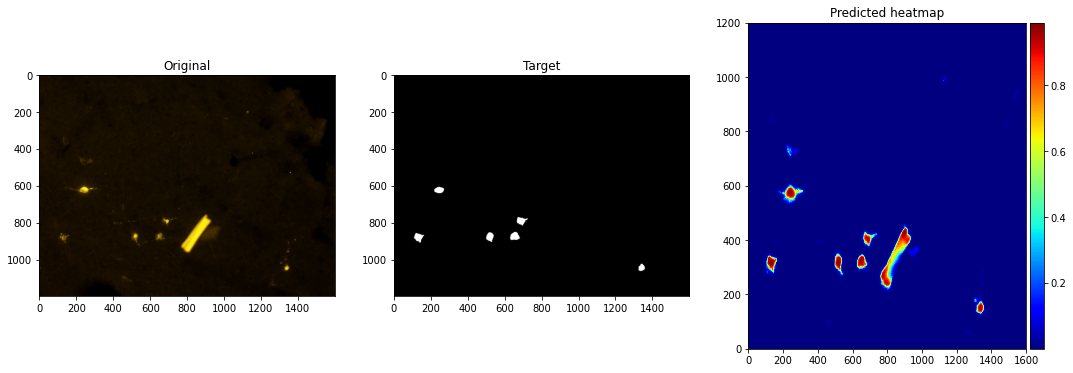

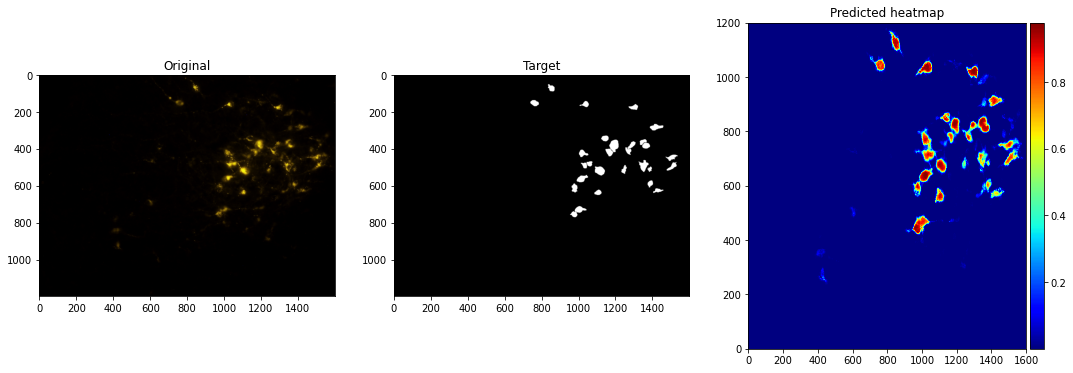

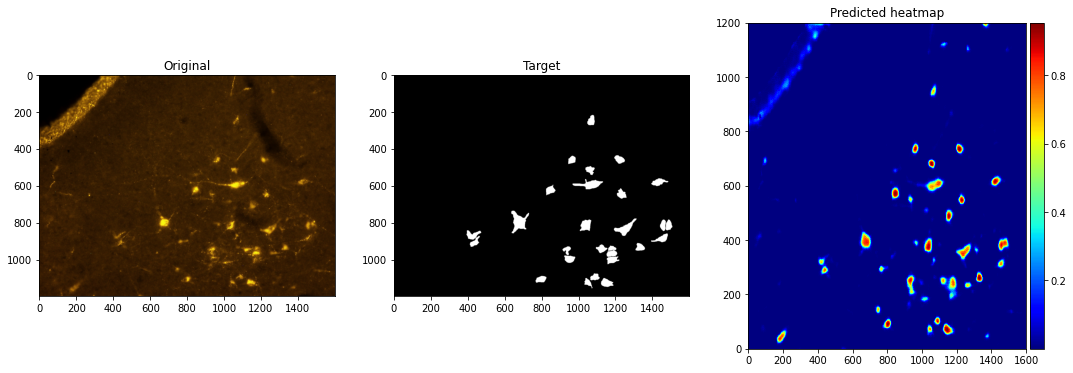

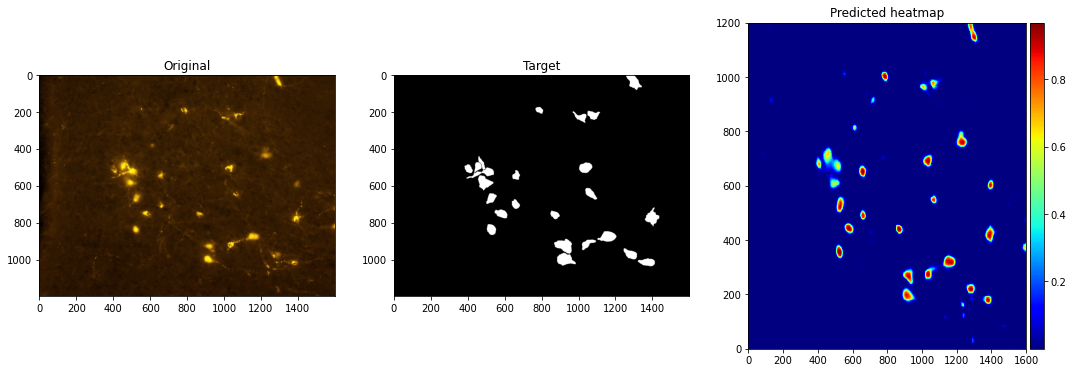

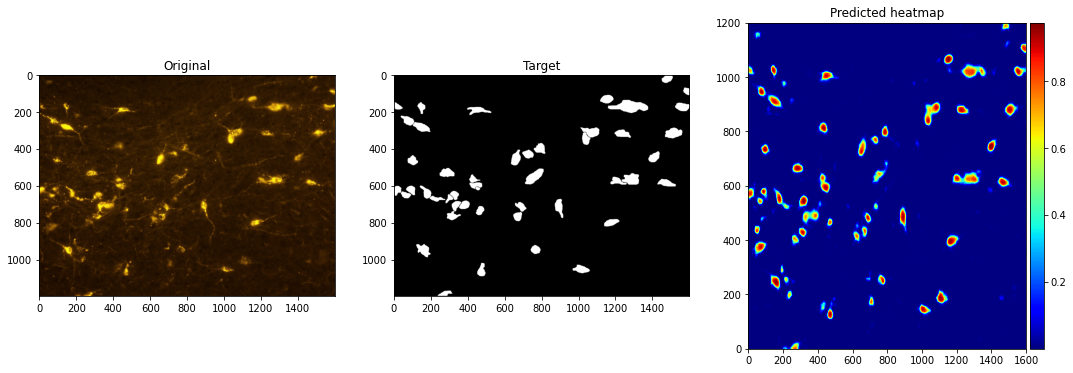

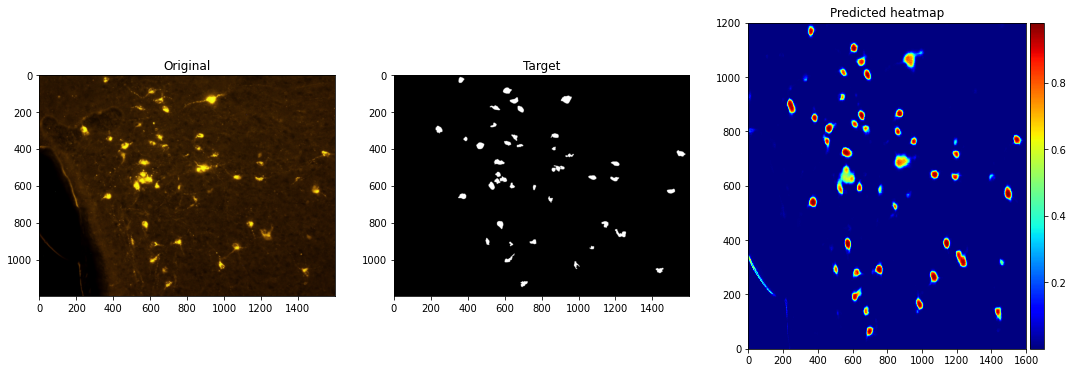

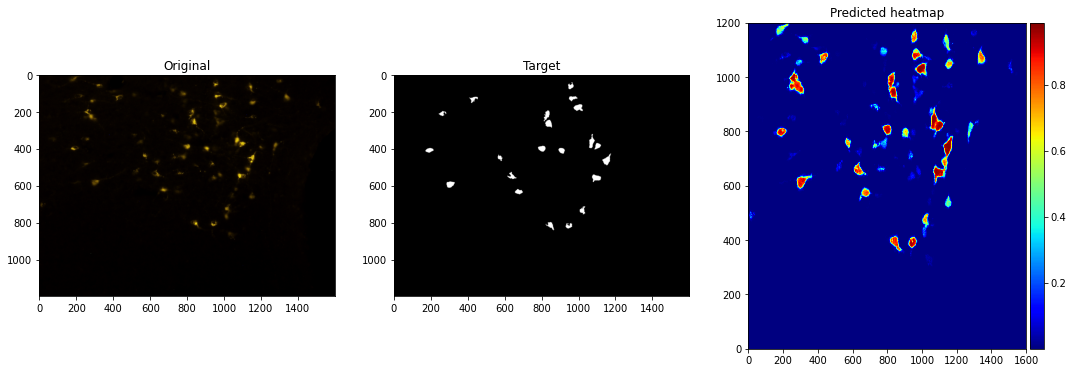

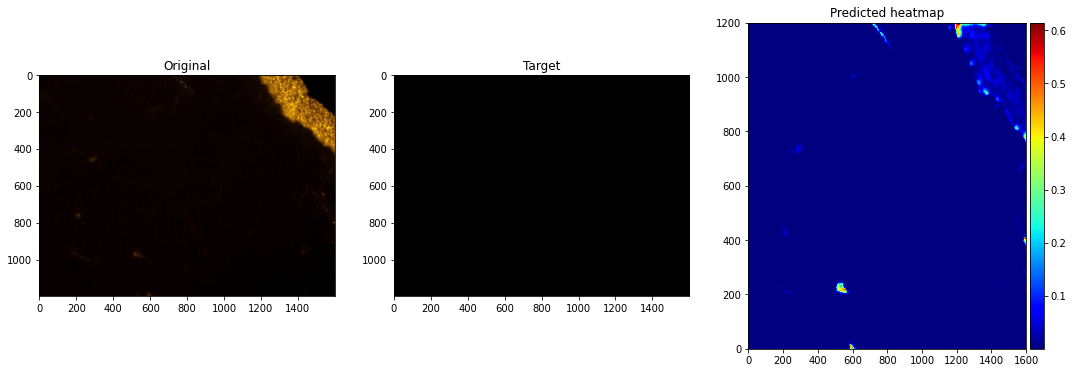

In [68]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    heat_map = heatmap[i]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
       
    im = axes[0].imshow(original)
    axes[0].set_title('Original')

    im = axes[1].imshow(np.squeeze(target), cmap='gray')
    axes[1].set_title('Target')

    im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    axes[2].set_title('Predicted heatmap') 
    
    if save:
        if os.path.exists('../figure_results/{}/{}'.format(model_name.split('.')[0], dataset)):
            print('path alredy exixts')
        else:
            os.makedirs('../figure_results/{}/{}'.format(model_name.split('.')[0], dataset))
        
        plt.savefig('../figure_results/{}/{}/{}_{}.png'.format(model_name.split('.')[0], \
                                                               dataset, model_name.split('.')[0],i))

In [73]:
list(list(model.children())[0].children())

[ModuleDict(
   (colorspace): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
   (conv_block): ConvBlock(
     (conv_block): ModuleDict(
       (batchnorm2d_0): BatchNorm2d(1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
       (activation_1): ELU(alpha=1.0)
       (conv2d_2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (batchnorm2d_3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
       (activation_4): ELU(alpha=1.0)
       (conv2d_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     )
   )
   (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (residual_block1): ResidualBlock(
     (conv_path): ConvBlock(
       (conv_block): ModuleDict(
         (batchnorm2d_0): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
         (activation_1): ELU(alpha=1.0)
         (conv2d_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(

In [ ]:
counter=0
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []# get all the model children as list
for block in blocks:
    for c in list(block.children()):
        if type(c) == nn.Conv2d:
            counter+=1
            model_weights.append(c.weight)
            conv_layers.append(c)
        else:
            for cc in list(c.children()):
                if type(cc) == nn.Conv2d:
                    counter+=1
                    model_weights.append(cc.weight)
                    conv_layers.append(cc)
                else:
                    for ccc in list(cc.children()):
                        if type(ccc) == nn.Conv2d:
                            counter+=1
                            model_weights.append(ccc.weight)
                            conv_layers.append(ccc)
                        else:
                            for cccc in list(ccc.children()):
                                if type(cccc) == nn.Conv2d:
                                    counter+=1
                                    model_weights.append(cccc.weight)
                                    conv_layers.append(cccc)
                                else:
                                    for ccccc in list(cccc.children()):
                                        if type(ccccc) == nn.Conv2d:
                                            counter+=1
                                            model_weights.append(ccccc.weight)
                                            conv_layers.append(ccccc)              

In [89]:
 model.module.encoder.colorspace

Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))

In [127]:
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
    return hook

model.module.encoder.colorspace

# register forward hooks on the layers of choice
#h1 = model.module.encoder.colorspace.register_forward_hook(getActivation('Conv2d'))
#h2 = model.maxpool.register_forward_hook(getActivation('maxpool'))
#h3 = model.layer3[0].downsample[1].register_forward_hook(getActivation('comp'))

In [ ]:
from types import MethodType

def _forward_impl_my(self, x):
    downblocks = []
    for lbl, layer in self.encoder.items():
        x = layer(x)
        if 'block' in lbl: downblocks.append(x)
        # NEXT loop is hon the values and so we don't hane the name as in the items of the previous loop
    for layer, long_connect in zip(self.decoder.values(), reversed(downblocks)):
        x = layer(x, long_connect)
    return self.head(x)

model._forward_impl = MethodType(_forward_impl_my, model)